# Setup

In [211]:
import os
os.chdir('../..')

In [212]:
import torch

from tqdm import tqdm
from torch import Tensor as _T

import matplotlib.pyplot as plt
from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.cm as cmx
import matplotlib.colors as colors

import numpy as np

In [327]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


# analysis_args = ConfigNamepace.from_yaml_path(sys.argv[1], strict_access = True)
# yaml_name = sys.argv[1].split('/')[-1].split('.')[0]
# save_base = '/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/fixed_points'
# save_path = os.path.join(save_base, yaml_name)
# _, save_path, _ = configure_logging_paths(save_path, [])
# analysis_args.write_to_yaml(os.path.join(save_path, "args.yaml"))
# print(save_path)
# run_name = analysis_args.run_name


# run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# run_name = 'run_a3_probe_cued_diffusion_no_swap_0'
run_name = 'run_a4_probe_cued_diffusion_flat_swap_0'
# run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_0'


_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


# Stimulus design

In [328]:
grid_points = 12
minimum_margin = torch.pi / task.task_variable_gen.min_sep

# Create unique feature values evenly spaced around the circle
unique_feature_values = torch.linspace(0, 2 * torch.pi, grid_points+1)[:-1]
unique_feature_values = rectify_angles(unique_feature_values)

# Create all possible combinations
stim1_grid, stim2_grid = torch.meshgrid(unique_feature_values, unique_feature_values, indexing='ij')
stim1_probe_features = stim1_grid.reshape(-1, 1)
stim2_probe_features = stim2_grid.reshape(-1, 1)

# Stack them together
all_probe_features = torch.cat([stim1_probe_features, stim2_probe_features], dim=1)
all_report_features = all_probe_features.clone()

all_probe_features = all_probe_features.unsqueeze(1).repeat(1, grid_points * grid_points, 1).reshape(grid_points ** 4, 2)
all_report_features = all_report_features.unsqueeze(0).repeat(grid_points * grid_points, 1, 1).reshape(grid_points ** 4, 2)

all_probe_features = all_probe_features.repeat(2, 1)
all_report_features = all_report_features.repeat(2, 1)

# Create mask for valid combinations (respecting minimum margin)
probe_angle_diff = rectify_angles(all_probe_features[:,0] - all_probe_features[:,1])
report_angle_diff = rectify_angles(all_report_features[:,0] - all_report_features[:,1])
valid_trial_mask = (probe_angle_diff.abs() >= minimum_margin) & (report_angle_diff.abs() >= minimum_margin)

selected_feature_idx = torch.concat([torch.zeros(grid_points ** 4), torch.ones(grid_points ** 4)]).int()

batch_size = valid_trial_mask.sum()
num_samples = 1

# Run trial

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


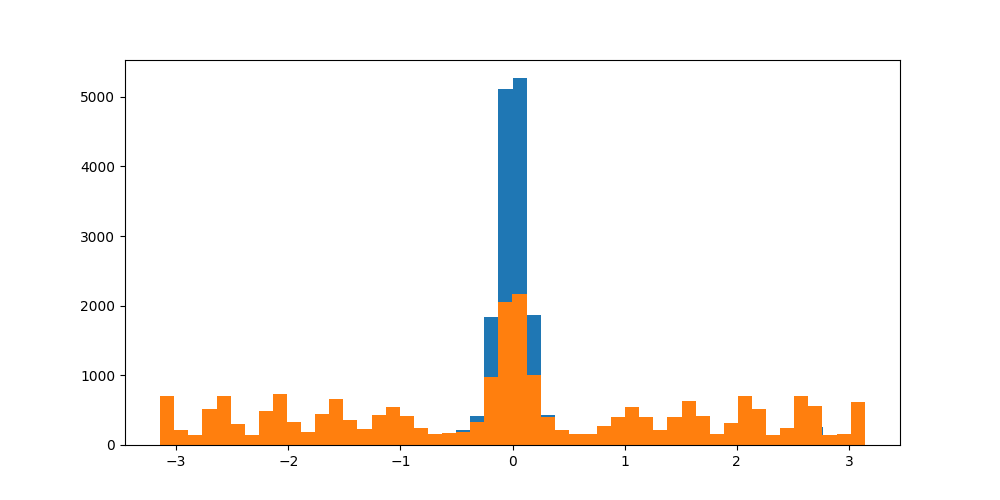

In [329]:
override_stimulus_features = {
    'probe_features': all_probe_features[valid_trial_mask],
    'report_features': all_report_features[valid_trial_mask],
}
override_stimulus_cart_features = {}
for k in override_stimulus_features.keys():
    override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

override_stimulus_features_dict = dict(
    **override_stimulus_features,
    **override_stimulus_cart_features,
    cued_item_idx = selected_feature_idx[valid_trial_mask]
)

task_variable_dict = task.task_variable_gen.generate_variable_dict(
    batch_size = batch_size,
    override_stimulus_features_dict=override_stimulus_features_dict
)

trial_information = task.generate_trial_information(
    batch_size=batch_size, num_samples=num_samples, override_task_variable_information = task_variable_dict
)

all_feature_data = torch.concat([
    trial_information.task_variable_information['probe_features_cart'].reshape(batch_size, 4),
    trial_information.task_variable_information['report_features_cart'].reshape(batch_size, 4),
], dim = -1)


with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[batch_size, num_samples],
        noise_scaler=1.0,
    )



actual_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'].squeeze(1)[:,[1,0]].T) - all_report_features[valid_trial_mask][range(valid_trial_mask.sum()), selected_feature_idx[valid_trial_mask]]).numpy()
swapped_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'].squeeze(1)[:,[1,0]].T) - all_report_features[valid_trial_mask][range(valid_trial_mask.sum()), 1 - selected_feature_idx[valid_trial_mask]]).numpy()

fig = plt.figure(figsize = (10, 5))
plt.hist(actual_errors, 50)
plt.hist(swapped_errors, 50)
plt.show()

# Report representation during delay

In [330]:
all_both_probe_fixed_masks = []
all_only_stim2_report_changes_masks: list[list] = []
all_only_stim1_report_changes_masks: list[list] = []

unique_probe_combinations = all_probe_features[::grid_points*grid_points]

for i in range(grid_points ** 2):

    probe_comb = unique_probe_combinations[[i]]
    both_probe_fixed_mask = (all_probe_features == probe_comb).all(-1)[valid_trial_mask]
    all_both_probe_fixed_masks.append(both_probe_fixed_mask)

    if not both_probe_fixed_mask.sum():
        continue

    all_only_stim2_report_changes_masks.append([])
    all_only_stim1_report_changes_masks.append([])

    for fval in unique_feature_values[:,None,None]:

        stim1_like_fval_mask = (all_report_features[:,[0]] == fval).squeeze(-1)
        all_only_stim2_report_changes_masks[-1].append(both_probe_fixed_mask & stim1_like_fval_mask[valid_trial_mask])

        stim2_like_fval_mask = (all_report_features[:,[1]] == fval).squeeze(-1)
        all_only_stim1_report_changes_masks[-1].append(both_probe_fixed_mask & stim2_like_fval_mask[valid_trial_mask])


swapped_mask = torch.tensor(np.abs(swapped_errors) < np.abs(actual_errors)).bool()
swapped_mask.float().mean()

tensor(0.3291)

In [344]:
pcaed_data[stim1_cued_mask & (~relevant_swapped_mask_stim1)].shape, cmap_colors[relevant_swapped_mask_stim1[stim1_cued_mask]].numpy().shape

((6, 3), (3, 4))

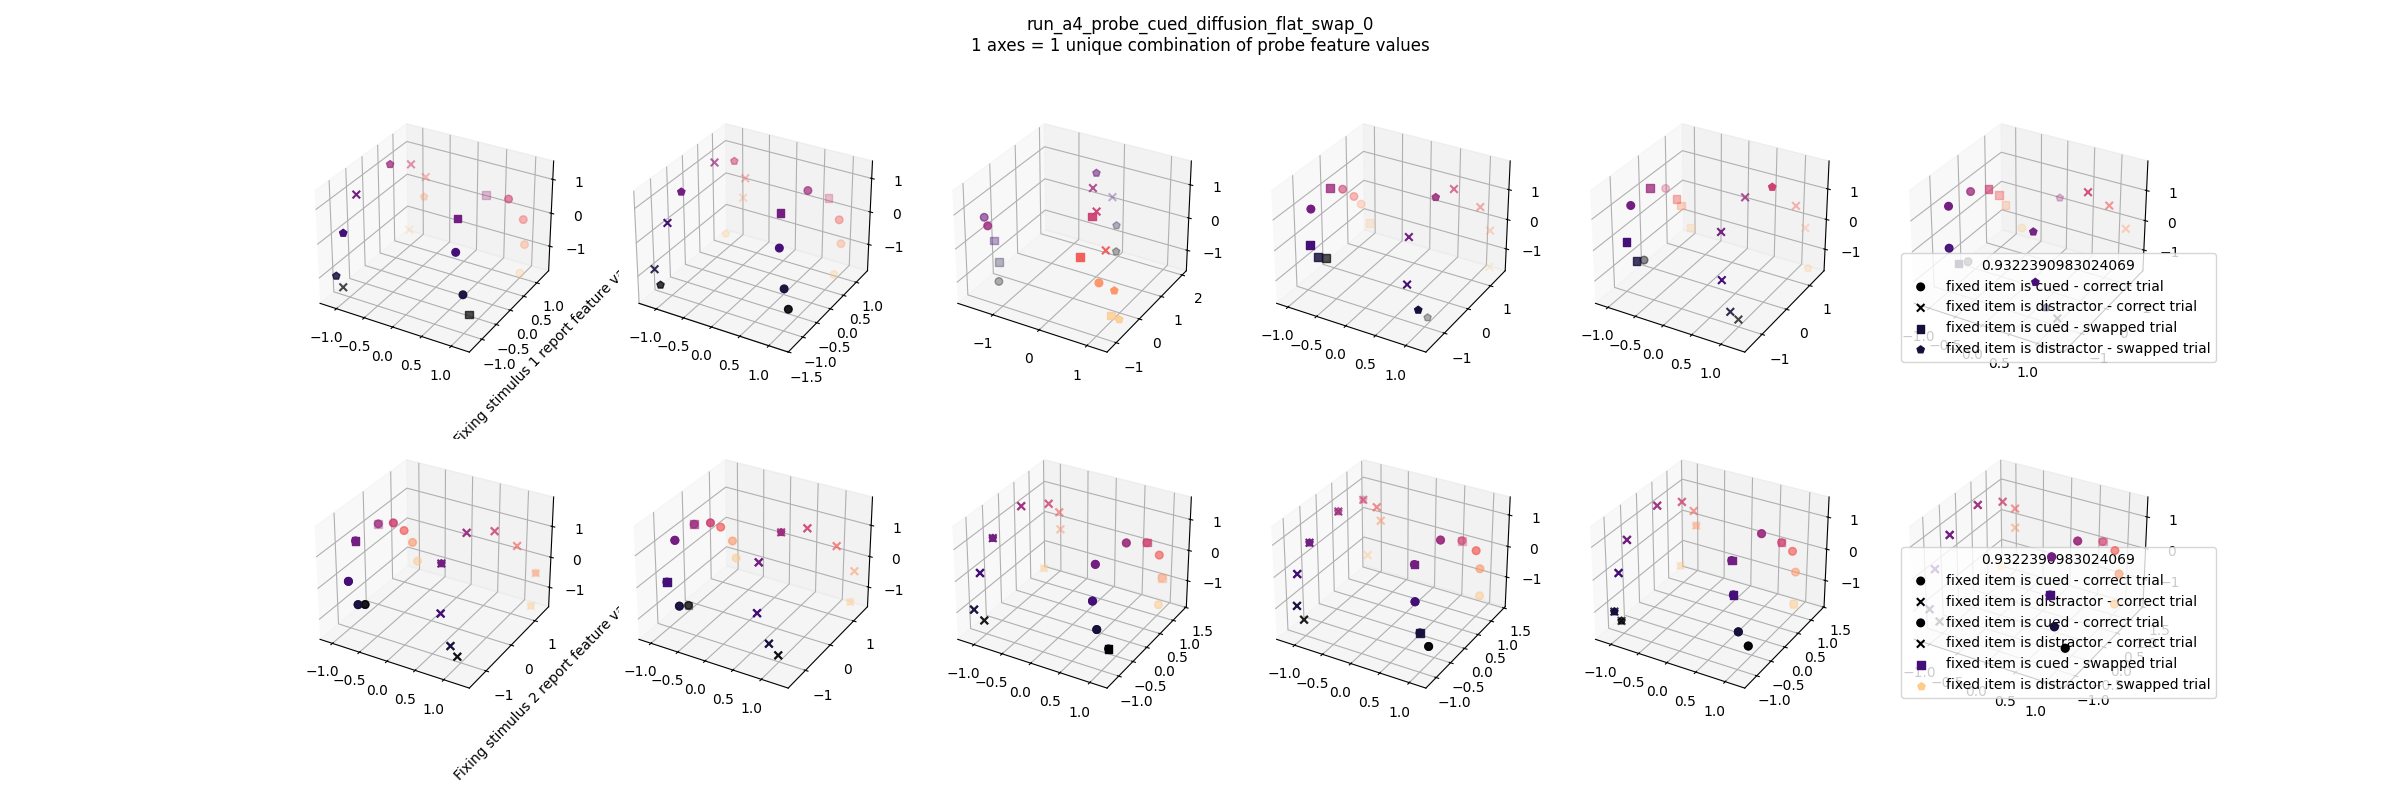

In [354]:
# (novel_samples_dict['embedded_sample_trajectory'] @ ddpm_model.auxiliary_embedding_matrix.cpu().T) == novel_samples_dict['sample_trajectory']

# pcaable_data = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
pcaable_data = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.sample_subspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()

num_probe_combs = 6

magma = plt.get_cmap("magma")
cNorm = colors.Normalize(vmin=0, vmax=9)
cmap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
cmap_colors = torch.tensor([cmap.to_rgba(_) for _ in range(9)])
cmap.set_array([])

pca_dims = 3

fig = plt.figure(figsize = (4 * num_probe_combs, 8))
ax_rows = 2
ax_cols = num_probe_combs
axes = [[fig.add_subplot(ax_rows, ax_cols, 1 + r * ax_cols + c, projection='3d' if pca_dims == 3 else None) for c in range(ax_cols)] for r in range(ax_rows)]
axes = np.array(axes)


fig.suptitle(f'{run_name}\n1 axes = 1 unique combination of probe feature values')
axes[0,0].set_ylabel('Fixing stimulus 1 report feature value')
axes[1,0].set_ylabel('Fixing stimulus 2 report feature value')

for ii, fixed_stim1_probe_masks in enumerate(all_both_probe_fixed_masks[:num_probe_combs]):

    all_pca_components_fixed_report1 = []
    all_pca_components_fixed_report2 = []
    
    for fixed_report1_mask, fixed_report2_mask in zip(all_only_stim2_report_changes_masks[ii], all_only_stim1_report_changes_masks[ii]):

        relevant_swapped_mask_stim1 = swapped_mask[fixed_report1_mask]
        relevant_swapped_mask_stim2 = swapped_mask[fixed_report2_mask]
        
        #assert ((fixed_stim1_probe_masks | fixed_report1_mask) == fixed_stim1_probe_masks).all()
        #assert ((fixed_stim1_probe_masks | fixed_report2_mask) == fixed_stim1_probe_masks).all()

        stim1_cued_mask = (selected_feature_idx[valid_trial_mask][fixed_report1_mask] == 0)
        stim2_cued_mask = (selected_feature_idx[valid_trial_mask][fixed_report2_mask] == 1)
        
        pcaable_data_fixed_report1 = pcaable_data[fixed_report1_mask]
        pca_obj_fixed_report1 = PCA(n_components=pca_dims, whiten = True).fit(pcaable_data_fixed_report1)
        pcaed_data = pca_obj_fixed_report1.transform(pcaable_data_fixed_report1)
        axes[0,ii].scatter(*pcaed_data[stim1_cued_mask & (~relevant_swapped_mask_stim1)].T, s = 30, color = cmap_colors[(~relevant_swapped_mask_stim1)[stim1_cued_mask]].numpy(), marker = 'o', label = 'fixed item is cued - correct trial')
        axes[0,ii].scatter(*pcaed_data[~stim1_cued_mask & (~relevant_swapped_mask_stim1)].T, s = 30, color = cmap_colors[(~relevant_swapped_mask_stim1)[~stim1_cued_mask]].numpy(), marker = 'x', label = 'fixed item is distractor - correct trial')
        axes[0,ii].scatter(*pcaed_data[stim1_cued_mask & (relevant_swapped_mask_stim1)].T, s = 30, color = cmap_colors[(relevant_swapped_mask_stim1)[stim1_cued_mask]].numpy(), marker = 's', label = 'fixed item is cued - swapped trial')
        axes[0,ii].scatter(*pcaed_data[~stim1_cued_mask & (relevant_swapped_mask_stim1)].T, s = 30, color = cmap_colors[(relevant_swapped_mask_stim1)[~stim1_cued_mask]].numpy(), marker = 'p', label = 'fixed item is distractor - swapped trial')
        # all_pca_components_fixed_report1.append(pca_obj_fixed_report1.components_)

        pcaable_data_fixed_report2 = pcaable_data[fixed_report2_mask]
        pca_obj_fixed_report2 = PCA(n_components=pca_dims, whiten = True).fit(pcaable_data_fixed_report2)
        pcaed_data = pca_obj_fixed_report2.transform(pcaable_data_fixed_report2)
        axes[1,ii].scatter(*pcaed_data[stim2_cued_mask].T, s = 30, color = cmap_colors, label = 'fixed item is cued - correct trial')
        axes[1,ii].scatter(*pcaed_data[~stim2_cued_mask].T, s = 30, color = cmap_colors, marker = 'x', label = 'fixed item is distractor - correct trial')

        axes[1,ii].scatter(*pcaed_data[stim2_cued_mask & (~relevant_swapped_mask_stim2)].T, s = 30, color = cmap_colors[(~relevant_swapped_mask_stim2)[stim2_cued_mask]].numpy(), marker = 'o', label = 'fixed item is cued - correct trial')
        axes[1,ii].scatter(*pcaed_data[~stim2_cued_mask & (~relevant_swapped_mask_stim2)].T, s = 30, color = cmap_colors[(~relevant_swapped_mask_stim2)[~stim2_cued_mask]].numpy(), marker = 'x', label = 'fixed item is distractor - correct trial')
        axes[1,ii].scatter(*pcaed_data[stim2_cued_mask & (relevant_swapped_mask_stim2)].T, s = 30, color = cmap_colors[(relevant_swapped_mask_stim2)[stim2_cued_mask]].numpy(), marker = 's', label = 'fixed item is cued - swapped trial')
        axes[1,ii].scatter(*pcaed_data[~stim2_cued_mask & (relevant_swapped_mask_stim2)].T, s = 30, color = cmap_colors[(relevant_swapped_mask_stim2)[~stim2_cued_mask]].numpy(), marker = 'p', label = 'fixed item is distractor - swapped trial')
        # all_pca_components_fixed_report2.append(pca_obj_fixed_report2.components_)

        break


axes[0,ii].legend(title = pca_obj_fixed_report1.explained_variance_ratio_.sum().item())
axes[1,ii].legend(title = pca_obj_fixed_report1.explained_variance_ratio_.sum().item())


    # all_parallelism_tests_fixed_report1 = []
    # for ci1, pcacomp1 in enumerate(all_pca_components_fixed_report1):
    #     for pcacomp2 in all_pca_components_fixed_report1[ci1+1:]:
    #         all_parallelism_tests_fixed_report1.append(
    #             np.max(np.arccos(np.clip(np.linalg.svd(pcacomp1 @ pcacomp2.T, compute_uv=True).S, -1.0, 1.0))) / np.pi * 180
    #         )

    # all_parallelism_tests_fixed_report2 = []
    # for ci1, pcacomp1 in enumerate(all_pca_components_fixed_report2):
    #     for pcacomp2 in all_pca_components_fixed_report2[ci1+1:]:
    #         all_parallelism_tests_fixed_report2.append(
    #             np.max(np.arccos(np.clip(np.linalg.svd(pcacomp1 @ pcacomp2.T, compute_uv=True).S, -1.0, 1.0))) / np.pi * 180
    #         )
    
    # axes[1,ii].hist(all_parallelism_tests_fixed_report1, 50)
    # axes[3,ii].hist(all_parallelism_tests_fixed_report2, 50)

# Fixed point analysis

In [ ]:






def energy_function(neural_response: _T):
    delay_input = trial_information.prep_network_inputs[prep_epoch_idx]
    assert (delay_input == 0.0).all()
    time_embedding = ddpm_model.prep_time_embedding.expand(delay_duration, ddpm_model.prep_time_embedding.shape[1])
    network_input = ddpm_model.input_model(delay_input, delay_duration)
    xdot: _T = - neural_response + ddpm_model.residual_model(neural_response, time_embedding, network_input)
    return 0.5 * xdot.square().sum()


num_fp_opt_steps = 100000
activity_patterns = torch.nn.Parameter(delay_activity, requires_grad = True)
optim = torch.optim.Adam([activity_patterns], lr = 1e-2)

all_energies = []

for ots in tqdm(range(num_fp_opt_steps)):

    energy = energy_function(activity_patterns)
    total_energy = energy.mean()

    optim.zero_grad()
    total_energy.backward()
    optim.step()

    all_energies.append(total_energy.item())

    if ots % 100 == 0:

        plt.close('all')
        fig, axes = plt.subplots(2, 2, figsize = (20, 20))

        # Visualise PCA
        pcaable_data = activity_patterns.data[:,:,0,:].cpu().reshape(batch_size * num_samples, -1) # only one timestep rn
        pca = PCA(n_components=2, whiten = True).fit(pcaable_data)
        axes[0,1].scatter(*pca.transform(pcaable_data).T, c = color_array_flattened)

        # Visualise selected examples
        selected_pcaable_data = pcaable_data[only_stim2_changes_mask]
        pca_masked = PCA(n_components=2, whiten = True).fit(selected_pcaable_data)
        axes[1,0].scatter(*pca_masked.transform(selected_pcaable_data).T)

        # # Visualise CCA
        # item1_features = all_feature_data[:,[0,1,4,5]]
        # cca = CCA(n_components=2).fit(pcaable_data, item1_features)
        # activity_cross, stim_cross = cca.transform(pcaable_data, item1_features)
        # axes[1,0].scatter(*activity_cross.T, c = color_array_flattened)
        
        # Loss
        axes[0,0].plot(all_energies)
        
        fig.savefig('analysis/new_analysis/fixed_points_test.png')
